# Lecture 21: Clustering and machine learning

CBIO (CSCI) 4835/6835: Introduction to Computational Biology

## Overview and Objectives

It's nice when you're able to automate a lot of your data analysis. Unfortunately, quite a bit of this analysis is "fuzzy"--it doesn't have well-defined right or wrong answers, but instead relies on sophisticated algorithmic and statistical analyses. Fortunately, a lot of these analyses have been implemented in the `scikit-learn` Python library. By the end of this lecture, you should be able to:

 - Define clustering, the kinds of problems it is designed to solve, and the most popular clustering variants
 - Use SciPy to perform hierarchical clustering of expression data
 - Define machine learning
 - Understand when to use supervised versus unsupervised learning
 - Create a basic classifier

## Part 1: Clustering

What is **clustering**?

Wikipedia:

    Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense or another) to each other than to those in other groups (clusters).

Generally speaking, clustering is a hard problem, so it is difficult to identify a provably optimal clustering.

![cluster](ClusterPCAML/800px-ClusterAnalysis_Mouse.svg.png)

### $k$-means

In *k-means clustering* we are given a set of *d* -dimensional vectors and we want to identify *k* sets $S_i$ such that

$$\sum_{i=0}^k \sum_{x_j \in S_i} ||x_j - \mu_i||^2$$
is **minimized** where $\mu_i$ is the *mean* of cluster $S_i$.  That is, all points are close as possible to the 'center' of the cluster.

**Limitations**

 - Classical $k$-means requires that we be able to take an average of our points - *no arbitrary distance functions*.
 - Must provide $k$ as a parameter.
 - Clustering results are very sensitive to $k$; poor choice of $k$, poor clustering results.

The general algorithm for $k$-means is as follows:

1: Choose the initial set of $k$ centroids. These are essentially pseudo-datapoints that will be updated over the course of the algorithm.

2: Assign all the actual data points to one of the centroids--whichever centroid they're closest to.

3: Recompute the centroids based on the cluster assignments found in step 2.

4: Repeat until the centroids don't change very much.

### Visualizing $k$-means

https://www.naftaliharris.com/blog/visualizing-k-means-clustering/

### $K$-means examples

First let's make a toy data set...

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

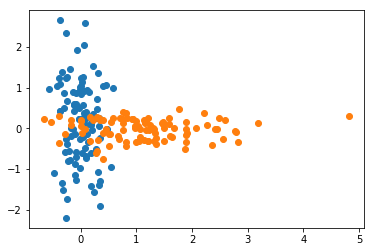

In [2]:
randpts1 = np.random.randn(100, 2) / (4, 1) #100 integer coordinates in the range [0:50],[0:50]
randpts2 = (np.random.randn(100, 2) + (1, 0)) / (1, 4)
 
plt.plot(randpts1[:, 0], randpts1[:, 1], 'o', randpts2[:, 0], randpts2[:, 1], 'o')
X = np.vstack((randpts1,randpts2))

In [3]:
import sklearn.cluster as cluster

kmeans = cluster.KMeans(n_clusters = 2)
kmeans.fit(X)

# Get the cluster assignments.
clusters = kmeans.labels_

# Get the centroids.
means = kmeans.cluster_centers_

The means are the cluster centers

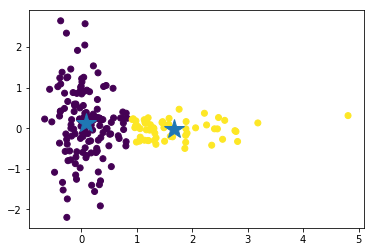

In [4]:
plt.scatter(X[:, 0], X[:, 1], c = clusters)
plt.plot(means[:, 0], means[:, 1], '*', ms = 20);

### Changing $k$

Let's look at what happens if we change from $k = 2$ to $k = 3$.

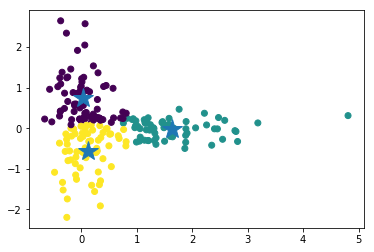

In [5]:
kmeans = cluster.KMeans(n_clusters = 3)
kmeans.fit(X)

clusters, means = kmeans.labels_, kmeans.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c = clusters)
plt.plot(means[:, 0], means[:, 1], '*', ms = 20);

And for $k = 4$

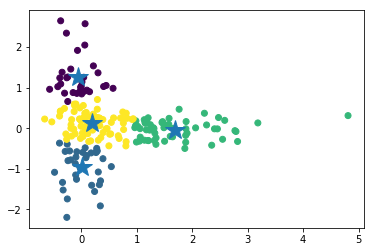

In [6]:
kmeans = cluster.KMeans(n_clusters = 4)
kmeans.fit(X)

clusters, means = kmeans.labels_, kmeans.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c = clusters)
plt.plot(means[:, 0], means[:, 1], '*', ms = 20);

Will K-means always find the same set of clusters?

 - Yes
 - No

### Hierarchical clustering

Hierarchical clustering creates a heirarchy, where each cluster is formed from subclusters.

![hierarchy](ClusterPCAML/Clustering_h1.png)

There are two kinds of hierarchical clustering: *agglomerative* and *divisive*.

 - *Agglomerative* clustering builds the hierarchy from the bottom up: start with all data points as their own clusters, find the two clusters that are closest, combine them into a cluster, repeat.

 - *Divisive* clustering is the opposite: start with all data points as part of a single huge cluster, find the groups that are most different, and split them into separate clusters. Repeat.

Which do you think is easier, in practice?

### Agglomerative clustering

Agglomerative clustering requires there be a notion of distance between *clusters of items*, not just the items themselves (why?).

On the other hand, all you need is a distance function. You do *not* need to be able to take an average, as with $k$-means.

### Distance (Linkage) Methods

![distances](ClusterPCAML/clustering_distances.png)

* **average**: 
$$d(u,v) = \sum_{ij}\frac{d(u_i,v_j)}{|u||v|}$$
* **complete** or farthest point: 
$$d(u,v) = \max(dist(u_i,v_j))$$
* **single** or nearest point: 
$$d(u,v) = \min(dist(u_i,v_j))$$

### `linkage`

`scipy.cluster.hierarchy.linkage` creates a clustering hierarchy. It takes three parameters:
 * *y* the data or a precalculated distance matrix
 * *method* the linkage method (default single)
 * *metric* the distance metric to use (default euclidean)

In [7]:
import scipy.cluster.hierarchy as hclust
Z = hclust.linkage(X) 

 - An $(n - 1) \times 4$ matrix $Z$ is returned.
 - At the $i^{th}$ iteration, clusters with indices `Z[i, 0]` and `Z[i, 1]` are combined to form cluster $n + i$.
 - A cluster with an index less than $n$ corresponds to one of the $n$ original observations.
 - The distance between clusters `Z[i, 0]` and `Z[i, 1]` is given by `Z[i, 2]`.
 - The fourth value `Z[i, 3]` represents the number of original observations in the newly formed cluster.

In [8]:
print(X.shape)
print(Z)
print(Z.shape)

(200, 2)
[[5.20000000e+01 8.00000000e+01 5.46104484e-03 2.00000000e+00]
 [1.11000000e+02 1.20000000e+02 5.75628114e-03 2.00000000e+00]
 [7.60000000e+01 1.99000000e+02 7.59955496e-03 2.00000000e+00]
 [5.00000000e+00 4.20000000e+01 1.12296562e-02 2.00000000e+00]
 [3.70000000e+01 9.30000000e+01 1.62556168e-02 2.00000000e+00]
 [6.90000000e+01 1.89000000e+02 1.66985682e-02 2.00000000e+00]
 [1.04000000e+02 1.29000000e+02 1.68648446e-02 2.00000000e+00]
 [2.02000000e+02 2.04000000e+02 1.76761477e-02 4.00000000e+00]
 [5.30000000e+01 9.70000000e+01 1.82930831e-02 2.00000000e+00]
 [1.27000000e+02 1.45000000e+02 1.92537400e-02 2.00000000e+00]
 [2.00000000e+00 1.25000000e+02 2.15373254e-02 2.00000000e+00]
 [1.54000000e+02 1.98000000e+02 2.37754345e-02 2.00000000e+00]
 [1.69000000e+02 1.88000000e+02 2.51246631e-02 2.00000000e+00]
 [1.64000000e+02 1.80000000e+02 2.51378410e-02 2.00000000e+00]
 [6.60000000e+01 2.08000000e+02 2.52241798e-02 3.00000000e+00]
 [1.82000000e+02 1.86000000e+02 2.53160649e-02

### Dendograms

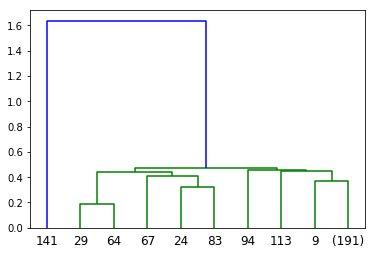

In [9]:
#show first 4 levels
hclust.dendrogram(Z, p = 4, truncate_mode = 'level');

### `fcluster`: extracting clusters from a hierarchy

`fcluster` takes a linkage matrix and returns a cluster assignment.  It takes a threshold value and a string specifying what method to use to form the cluster.

In [10]:
help(hclust.fcluster)

Help on function fcluster in module scipy.cluster.hierarchy:

fcluster(Z, t, criterion='inconsistent', depth=2, R=None, monocrit=None)
    Form flat clusters from the hierarchical clustering defined by
    the given linkage matrix.
    
    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded with the matrix returned
        by the `linkage` function.
    t : float
        The threshold to apply when forming flat clusters.
    criterion : str, optional
        The criterion to use in forming flat clusters. This can
        be any of the following values:
    
          ``inconsistent`` : 
              If a cluster node and all its
              descendants have an inconsistent value less than or equal
              to `t` then all its leaf descendants belong to the
              same flat cluster. When no non-singleton cluster meets
              this criterion, every node is assigned to its own
              cluster. (Default)
    
          ``distanc

### Flatten based on distance threshold

In [11]:
clusters = hclust.fcluster(Z, 0.3, 'distance')
len(set(clusters))

9

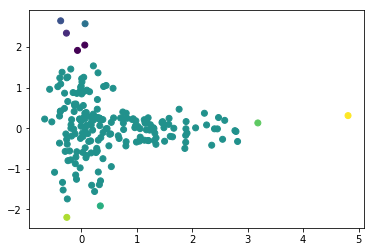

In [12]:
plt.scatter(X[:, 0], X[:, 1], c = clusters)

### Flatten based on number of clusters

In [13]:
clusters = hclust.fcluster(Z, 4, 'maxclust')
len(set(clusters))

4

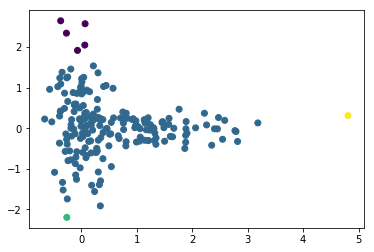

In [14]:
plt.scatter(X[:, 0], X[:, 1], c = clusters)

### `fclusterdata`

`fclusterdata` does both linkage and fcluster in one step.  Let's try out different linkage methods.

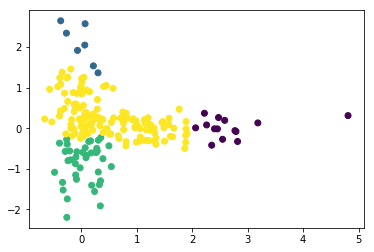

In [15]:
clusters = hclust.fclusterdata(X, 4, 'maxclust', method = 'complete')
plt.scatter(X[:, 0], X[:, 1], c = clusters)

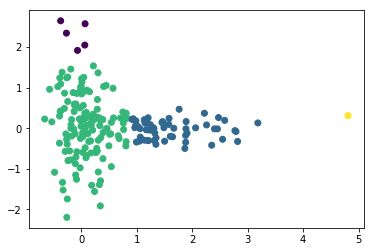

In [16]:
clusters = hclust.fclusterdata(X, 4, 'maxclust', method = 'average')
plt.scatter(X[:, 0], X[:, 1], c = clusters)

You can even use a non-Euclidean metric.

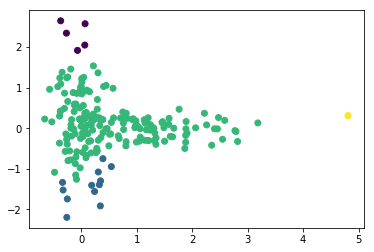

In [17]:
clusters = hclust.fclusterdata(X, 4, 'maxclust', method = 'average', metric = 'cityblock')
plt.scatter(X[:, 0], X[:, 1], c = clusters)

### `leaves_list`

A hierarchical cluster imposes an order on the leaves.  You can retrieve this ordering from the linkage matrix with `leaves_list`

In [18]:
hclust.leaves_list(Z)

array([141,  29,  64,  67,  24,  83,  94, 113,   9, 173,   3,  14,  12,
        26,  16,  84, 156, 166, 197, 150, 123, 142,  31,  15,  60,   0,
        54,  75,  48,  89, 103, 163,  85,  55, 110, 151, 119, 138, 136,
       183, 177, 122, 153, 106, 159, 117, 170, 157,  40,  91, 194,  56,
         5,  42, 165, 108, 116, 128, 184, 154, 198, 147, 148, 168,   8,
         7,  71,  18,  88,  13,  82,   1,  45,  33,  87, 109,  69, 189,
        46,  47,  49,  59,  90,  96,  66,  53,  97,  28,  70, 114, 144,
       100, 118, 196,  79,  68, 187,  50, 126, 127, 145, 175,   2, 125,
        98,  72,  86, 160,   4,  51,  65,  78,  52,  80, 104, 129,  22,
        58,  11, 178, 158,  39, 105, 140,  76, 199,  37,  93, 181, 185,
       190,  30,  73, 161, 143,  27,  38, 130,  34,  36,  57,  77, 191,
       162, 176, 132, 146, 101, 155, 169, 188, 107, 152, 195, 192, 131,
       134, 115, 135, 171, 137, 111, 120, 121, 167, 112, 174, 172, 102,
       164, 180, 139, 149, 179, 133, 182, 186, 124, 193,  21,  2

### Clustering expression data

 * Download [https://eds-uga.github.io/cbio4835-fa18/ClusterPCAML/Spellman.csv](https://eds-uga.github.io/cbio4835-fa18/ClusterPCAML/Spellman.csv)
 * read the expression data into a numpy array
 * cluster it with the default parameters
 * retrieve the leaves
 * reorder the orginal data according the the leaf order
 * display the result as a heatmap

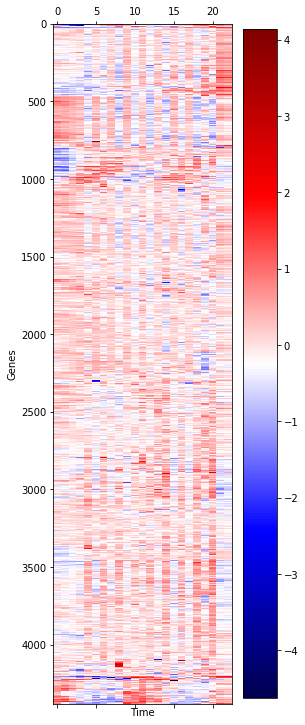

In [19]:
from matplotlib.pylab import cm
data = np.genfromtxt('ClusterPCAML/Spellman.csv',skip_header=1,delimiter=',')[:,1:]
Z = hclust.linkage(data,method='complete')
leaves = hclust.leaves_list(Z)
ordered = data[leaves]
plt.matshow(ordered, aspect = 0.02, cmap=cm.seismic);
plt.xlabel("Time")
plt.ylabel("Genes")
plt.colorbar()

## Part 2: Machine Learning

What is machine learning?

Wikipedia:

    Machine learning is a subfield of computer science that evolved from the study of pattern recognition and computational learning theory in artificial intelligence. Machine learning explores the study and construction of algorithms that can learn from and make predictions on data.

Dr. David Koes, University of Pittsburgh:

    Creating useful and/or predictive computational models from data.

Machine Learning can be considered a subfield of **Artificial Intelligence**.

These algorithms can be seen as building blocks to make computers learn to behave more intelligently by somehow **generalizing** rather that just storing and retrieving data items like a database system would do.

Here's an overly simple example:

![decision-boundary](ClusterPCAML/decision-boundary.png)

This may seem like a trivial task, but it is a simple version of a very important concept. By drawing this separating line, we have learned a model which can **generalize** to new data.

If you were to drop another point onto the plane which is unlabeled, this algorithm could now **predict** whether it's a blue or a red point.

### `scikit-learn`

[Scikit-Learn](http://github.com/scikit-learn/scikit-learn) is a Python package designed to give access to **well-known** machine learning algorithms within Python code, through a **clean, well-thought-out API**. It has been built by hundreds of contributors from around the world, and is used across industry and academia.

Scikit-Learn is built upon Python's [NumPy (Numerical Python)](http://numpy.org) and [SciPy (Scientific Python)](http://scipy.org) libraries, which enable efficient in-core numerical and scientific computation within Python.

### Representing Data

Machine learning is about creating models from data, and `scikit-learn` uses a particular layout for building its models.

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**, typically as ``numpy`` arrays. The shape of the array is expected to be `[n_samples, n_features]`

![data-layout](ClusterPCAML/data-layout.png)

### Example: the Iris dataset

As an example of a simple dataset, we're going to take a look at the iris data (stored in `scikit-learn`, along with dozens of other sample datasets).

The data consists of measurements of three different species of irises.

There are three species of iris in the dataset, which we can picture here:

Iris Setosa

![setosa](ClusterPCAML/iris_setosa.jpg)

Iris Versicolor

![versicolor](ClusterPCAML/iris_versicolor.jpg)

Iris Virginica

![virginica](ClusterPCAML/iris_virginica.jpg)

The iris data consists of the following:

- Features in the Iris dataset:

  1. sepal length in cm
  2. sepal width in cm
  3. petal length in cm
  4. petal width in cm

- Target classes to predict:

  1. Iris Setosa
  2. Iris Versicolour
  3. Iris Virginica

Accessing the iris data in `scikit-learn` is pretty easy:

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()  # "iris" is a DICTIONARY

We can examine this data more closely, using the properties of the various Python objects storing it:

In [21]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [22]:
n_samples, n_features = iris["data"].shape
print((n_samples, n_features))
print(iris["data"][0]) # the 0th data point

(150, 4)
[5.1 3.5 1.4 0.2]


In [23]:
print(iris["data"].shape)
print(iris["target"].shape)

(150, 4)
(150,)


In [24]:
print(iris["target"])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [25]:
print(iris["target_names"])

['setosa' 'versicolor' 'virginica']


This data is four dimensional, but we can visualize two of the dimensions at a time using a simple scatter-plot:

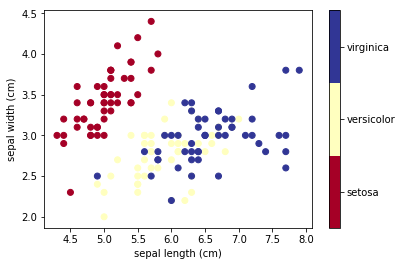

In [26]:
x_index = 0
y_index = 1

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

plt.scatter(iris.data[:, x_index], iris.data[:, y_index],
            c=iris.target, cmap=plt.cm.get_cmap('RdYlBu', 3))
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.clim(-0.5, 2.5)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index]);

### Unsupervised Learning

Imagine we didn't have the target data (i.e., iris species) available, and wanted to *cluster* the data into similar groups.

In this case, we're discovering an underlying structure in the data **without any *a priori* knowledge of categories or "ground truth".** Hence, *unsupervised*.

Other forms of unsupervised learning include:

 - dimensionality reduction, such as principal components analysis (PCA)
 - expectation-maximization ($k$-means is a variant)
 - self-organizing maps
 - other clustering algorithms

### Supervised learning

This is what we do in order to build models from data that **DO include some form of "ground truth" labels**.

The data consists of a set of examples *X* where each example has a corresponding label *y*.

Our assumption is that the label is a function of the data; our goal is to learn that function that maps *X* to *y* as accurately as possible: $y = f(X)$

![model](ClusterPCAML/model.png)

### Classification versus Regression

There are two types of supervised learning.

*Classification* maps an example to a discrete labels. This answers questions such as 
 - Will it rain tomorrow?
 - Is the protein overexpressed?
 - Do the cells die when a drug is added?

*Regression* maps an example to a continuous number. This answers questions such as
 - How much rain will there be tomorrow?
 - What is the expression level of the protein?
 - What percent of the cells will die when the drug is added?

### Flowchart for choosing your methods

This is a flow chart created by scikit-learn super-contributor [Andreas Mueller](https://github.com/amueller) which gives a nice summary of which algorithms to choose in various situations. Keep it around as a handy reference!

![ml-map](ClusterPCAML/ml_map.png)

### Back to iris

Given we have ground truth information (iris species), are we performing *supervised* or *unsupervised* learning on the iris data?

What if we didn't have grouth truth information? What kind of algorithms could we use?

What kind of supervised learning are we performing?

The iris data are 4-dimensional; can't exactly visualize that directly. We can, however, plot each pair of features in turn (this is called "getting a feel for the data").

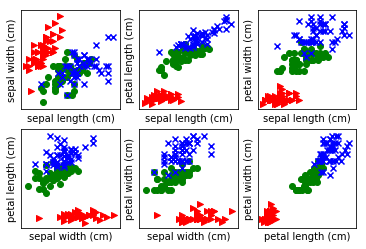

In [27]:
import itertools

features = iris.data
feature_names = iris.feature_names
classes = iris.target
feature_combos = itertools.combinations([0, 1, 2, 3], 2)

for i, (x1, x2) in enumerate(feature_combos):
    fig = plt.subplot(2, 3, i + 1)
    fig.set_xticks([])
    fig.set_yticks([])
    for t, marker, c in zip(range(3), ">ox", "rgb"):
        plt.scatter(features[classes == t, x1],
                   features[classes == t, x2],
                   marker = marker, c = c)
    plt.xlabel(feature_names[x1])
    plt.ylabel(feature_names[x2])

### Features

The features, *X*, are what make each example distinct. Ideally they contain enough information to predict *y*. In the case of the iris dataset, the features have to do with petal and sepal measurements.

The pairwise feature plots give us some good intuition for the data. For example:

 - The first plot, sepal width vs sepal length, gives us a really good separation of the Setosa (red triangles) from the other two, but a poor separation between Versicolor and Virginica
 - In fact, this is a common theme across most of the subplots--we can easily pick two dimensions and get a good separation of Setosa from the others, but separating Versicolor and Virginica may be more difficult
 - The best pairings for separating Versicolor and Virginica may be either petal length vs sepal width, or petal width vs sepal width.

Still, for any given pair of features, we can't get a *perfect* classification rule.

**But that's ok!**

### K-nearest neighbors (KNN)

Another algorithm with a $k$ in the name--this time, a supervised algorithm--is the simplest classifier you can design.

It asks, for any given data point $x$: **What are the labels of the $k$ data points closest to $x$?**

It then performs a majority vote, based on those labels. The winning label is assigned to the new data point $x$. The end!

Let's try it on the iris dataset.

In [28]:
from sklearn import neighbors

X = iris["data"][:, :2]  # For ease of interpretation
y = iris["target"]

# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)

# fit the model
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

That's it. We've trained our classifier! Now let's try to predict a new, previously-unobserved iris:

In [29]:
# What kind of iris has 3cm x 5cm sepal?
# call the "predict" method:
result = knn.predict([[3, 5],])

print(iris.target_names[result])

['setosa']


Our completely-made-up new mystery iris is classified as a setosa!

We can visualize what this algorithm looks like:

(4.2, 8.0, 1.9, 4.5)

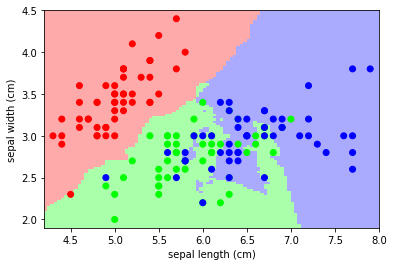

In [30]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

### IGNORE THIS ###
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap = cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = cmap_bold)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.axis('tight')

There are plenty of more sophisticated classifiers:
 - support vector machines
 - neural networks
 - decision trees
 - ...

Furthermore, you will often combine multiple methods into a machine learning *pipeline*. For example, rather than work directly with the 4D iris data, perhaps you'll run PCA on it first to reduce it to 2 dimensions, then classify it.

Machine learning is more of an art than a science; it takes a lot of "playing with the data" to find the right combination of model and pipeline that incorporates the right assumptions about the data and can generalize well.

`scikit-learn` makes it relatively easy to get started: you don't have to know how the algorithms are implemented underneath, but that knowledge does help in fine-tuning your pipelines.

## Administrivia

 - How is Assignment 5 going? Due **Thursday!**

 - How are projects going? Talks are **next week**, and write-ups are due **Thursday, April 23 by 11:59pm**.

 - We'll go over material for the final exam-lab next week.

 - Last lecture of the semester on Thursday!

## Additional Resources

 1. Richert, Willi and Pedro Coelho, Luis. *Building Machine Learning Systems with Python*. 2013. ISBN-13: 978-1782161400
 2. ACM Machine Learning Workshop https://github.com/eds-uga/acm-ml-workshop-2017/ (based on Jake VanderPlas' [scikit-learn tutorial](https://github.com/jakevdp/sklearn_tutorial))